# Using STGCN for speed prediction of the traffic

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/Aguin/STGCN-PyTorch.git

Cloning into 'STGCN-PyTorch'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 29 (delta 7), reused 26 (delta 7), pack-reused 0
Unpacking objects: 100% (29/29), 8.18 MiB | 4.19 MiB/s, done.


In [3]:
import torch
import numpy as np
import pandas as pd

def read_data(features_csv, adj_csv):
    urban_core_speeds = pd.read_csv(features_csv, header=None)
    adj_matrix_df = pd.read_csv(adj_csv, header=None)
    adj_matrix = np.array(adj_matrix_df)

    speeds_df = urban_core_speeds.iloc[:, 7:]
    speeds = np.array(speeds_df)
    
    return adj_matrix_df, urban_core_speeds, adj_matrix, speeds

adj_matrix_df, urban_core_speeds, adj_matrix, speeds = read_data(
    '../input/seoul-speed-data/urban-core.csv', 
    '../input/seoul-speed-data/Adj(urban-core).csv')

In [4]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class align(nn.Module):
    def __init__(self, c_in, c_out):
        super(align, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        if c_in > c_out:
            self.conv1x1 = nn.Conv2d(c_in, c_out, 1)

    def forward(self, x):
        if self.c_in > self.c_out:
            return self.conv1x1(x)
        if self.c_in < self.c_out:
            return F.pad(x, [0, 0, 0, 0, 0, self.c_out - self.c_in, 0, 0])
        return x

class temporal_conv_layer(nn.Module):
    def __init__(self, kt, c_in, c_out, act="relu"):
        super(temporal_conv_layer, self).__init__()
        self.kt = kt
        self.act = act
        self.c_out = c_out
        self.align = align(c_in, c_out)
        if self.act == "GLU":
            self.conv = nn.Conv2d(c_in, c_out * 2, (kt, 1), 1)
        else:
            self.conv = nn.Conv2d(c_in, c_out, (kt, 1), 1)

    def forward(self, x):
        x_in = self.align(x)[:, :, self.kt - 1:, :]
        if self.act == "GLU":
            x_conv = self.conv(x)
            return (x_conv[:, :self.c_out, :, :] + x_in) * torch.sigmoid(x_conv[:, self.c_out:, :, :])
        if self.act == "sigmoid":
            return torch.sigmoid(self.conv(x) + x_in)
        return torch.relu(self.conv(x) + x_in)

class spatio_conv_layer(nn.Module):
    def __init__(self, ks, c, Lk):
        super(spatio_conv_layer, self).__init__()
        self.Lk = Lk
        self.theta = nn.Parameter(torch.FloatTensor(c, c, ks))
        self.b = nn.Parameter(torch.FloatTensor(1, c, 1, 1))
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.theta, a=math.sqrt(5))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.theta)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.b, -bound, bound)

    def forward(self, x):
        x_c = torch.einsum("knm,bitm->bitkn", self.Lk, x)
        x_gc = torch.einsum("iok,bitkn->botn", self.theta, x_c) + self.b
        return torch.relu(x_gc + x)

class st_conv_block(nn.Module):
    def __init__(self, ks, kt, n, c, p, Lk):
        super(st_conv_block, self).__init__()
        self.tconv1 = temporal_conv_layer(kt, c[0], c[1], "GLU")
        self.sconv = spatio_conv_layer(ks, c[1], Lk)
        self.tconv2 = temporal_conv_layer(kt, c[1], c[2])
        self.ln = nn.LayerNorm([n, c[2]])
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_s = self.sconv(x_t1)
        x_t2 = self.tconv2(x_s)
        x_ln = self.ln(x_t2.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)        
        return self.dropout(x_ln)

class fully_conv_layer(nn.Module):
    def __init__(self, c):
        super(fully_conv_layer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class output_layer(nn.Module):
    def __init__(self, c, T, n):
        super(output_layer, self).__init__()
        self.tconv1 = temporal_conv_layer(T, c, c, "GLU")
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = temporal_conv_layer(1, c, c, "sigmoid")
        self.fc = fully_conv_layer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)

class STGCN(nn.Module):
    def __init__(self, ks, kt, bs, T, n, Lk, p):
        super(STGCN, self).__init__()
        self.st_conv1 = st_conv_block(ks, kt, n, bs[0], p, Lk)
        self.st_conv2 = st_conv_block(ks, kt, n, bs[1], p, Lk)
        self.output = output_layer(bs[1][2], T - 4 * (kt - 1), n)

    def forward(self, x):
        x_st1 = self.st_conv1(x)
        x_st2 = self.st_conv2(x_st1)
        return self.output(x_st2)

In [5]:
def scaled_laplacian(A):
    n = A.shape[0]
    d = np.sum(A, axis=1)
    L = np.diag(d) - A
    for i in range(n):
        for j in range(n):
            if d[i] > 0 and d[j] > 0:
                L[i, j] /= np.sqrt(d[i] * d[j])
    lam = np.linalg.eigvals(L).max().real
    return 2 * L / lam - np.eye(n)


def cheb_poly(L, Ks):
    n = L.shape[0]
    LL = [np.eye(n), L[:]]
    for i in range(2, Ks):
        LL.append(np.matmul(2 * L, LL[-1]) - LL[-2])
    return np.asarray(LL)


def evaluate_model(model, loss, data_iter):
    model.eval()
    l_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y in data_iter:
            y_pred = model(x).view(len(x), -1)
            l = loss(y_pred, y)
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        return l_sum / n

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
"""def data_transform(data, n_his, n_pred, day_slot, device):
    n_day = len(data) // day_slot
    n_route = data.shape[1]
    n_slot = day_slot - n_his - n_pred + 1
    x = np.zeros([n_day * n_slot, 1, n_his, n_route])
    y = np.zeros([n_day * n_slot, n_route])
    for i in range(n_day):
        for j in range(n_slot):
            t = i * n_slot + j
            s = i * day_slot + j
            e = s + n_his
            x[t, :, :, :] = data[s:e].reshape(1, n_his, n_route)
            y[t] = data[e + n_pred - 1]
    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)"""

'def data_transform(data, n_his, n_pred, day_slot, device):\n    n_day = len(data) // day_slot\n    n_route = data.shape[1]\n    n_slot = day_slot - n_his - n_pred + 1\n    x = np.zeros([n_day * n_slot, 1, n_his, n_route])\n    y = np.zeros([n_day * n_slot, n_route])\n    for i in range(n_day):\n        for j in range(n_slot):\n            t = i * n_slot + j\n            s = i * day_slot + j\n            e = s + n_his\n            x[t, :, :, :] = data[s:e].reshape(1, n_his, n_route)\n            y[t] = data[e + n_pred - 1]\n    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)'

In [8]:
adj_matrix.shape

(304, 304)

In [9]:
Ks, Kt = 3, 3
L = scaled_laplacian(adj_matrix)
Lk = cheb_poly(L, Ks)
Lk = torch.Tensor(Lk.astype(np.float32)).to(device)

In [10]:
Lk.shape

torch.Size([3, 304, 304])

In [27]:
train_test_split = 0.75

split = int(speeds.shape[1] * train_test_split)
train_data = speeds[:, :split]
test_data = speeds[:, split:]

print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (304, 6480)
Test data:  (304, 2160)


In [12]:
max_speed = train_data.max()
min_speed = train_data.min()
#scaler = StandardScaler()
#train_data = scaler.fit_transform(train_data)
#test_data = scaler.transform(test_data)
train_data = (train_data - min_speed) / (max_speed - min_speed)
test_data = (test_data - min_speed) / (max_speed - min_speed)

train_data.shape, test_data.shape

((304, 6480), (304, 2160))

In [13]:
seq_len = 10
pre_len = 12

def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY


trainX, trainY, testX, testY = sequence_data_preparation(seq_len, pre_len, train_data, test_data)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(6459, 304, 10)
(6459, 304)
(2139, 304, 10)
(2139, 304)


In [14]:
trainX = torch.Tensor(trainX).reshape(6459, 1, 10, 304).to(device)
testX = torch.Tensor(testX).reshape(2139, 1, 10, 304).to(device)
trainY = torch.Tensor(trainY).reshape(6459, 304).to(device)
testY = torch.Tensor(testY).reshape(2139, 304).to(device)

In [15]:
n_his = 10
n_pred = 2
day_slot = 12*24 #12 slots per hour X 24 hours

In [16]:
y_test, y_train, x_test, x_train = testY, trainY, testX, trainX
x_train.shape,y_train.shape, x_test.shape, y_test.shape

(torch.Size([6459, 1, 10, 304]),
 torch.Size([6459, 304]),
 torch.Size([2139, 1, 10, 304]),
 torch.Size([2139, 304]))

In [17]:
batch_size = 32
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [18]:
num_sensors = 304
Ks, Kt = 3, 3
blocks = [[1, 32, 64], [64, 32, 128]]
drop_prob = 0 
lr = 0.01

loss = nn.MSELoss()
model = STGCN(Ks, Kt, blocks, n_his, num_sensors, Lk, drop_prob).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
epochs = 50

min_val_loss = np.inf
for epoch in range(1, epochs + 1):
    l_sum, n = 0.0, 0
    model.train()
    for x, y in train_iter:
        y_pred = model(x).view(len(x), -1)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        l_sum += l.item() * y.shape[0]
        n += y.shape[0]
        
    val_loss = evaluate_model(model, loss, test_iter)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
    print("epoch", epoch, ", train loss:", l_sum / n, ", validation loss:", val_loss)

epoch 1 , train loss: 0.03513909697032026 , validation loss: 0.005328463681643919
epoch 2 , train loss: 0.010143397883345541 , validation loss: 0.0053850761797608285
epoch 3 , train loss: 0.008684201512305794 , validation loss: 0.005389745682351685
epoch 4 , train loss: 0.007662767558591476 , validation loss: 0.005437908933400871
epoch 5 , train loss: 0.0072405924928293985 , validation loss: 0.0055131209817640536
epoch 6 , train loss: 0.006953569776954611 , validation loss: 0.005524653428381761
epoch 7 , train loss: 0.006821298754045442 , validation loss: 0.0055402748822484926
epoch 8 , train loss: 0.0066165680849855765 , validation loss: 0.005547105412200519
epoch 9 , train loss: 0.006398125887315078 , validation loss: 0.005131348798616627
epoch 10 , train loss: 0.0051053862656185636 , validation loss: 0.003743119811479833
epoch 11 , train loss: 0.0038781680430877243 , validation loss: 0.0034150958740226003
epoch 12 , train loss: 0.003828969731884238 , validation loss: 0.0032504137058

In [20]:
def evaluate_metric(model, data_iter):
    model.eval()
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = y.cpu().numpy().reshape(-1)
            y_pred = model(x).view(len(x), -1).cpu().numpy().reshape(-1)
            y *= max_speed
            y_pred *= max_speed
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / y).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        MAPE = np.array(mape).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, MAPE, RMSE

In [21]:
l = evaluate_model(model, loss, test_iter)
MAE, MAPE, RMSE = evaluate_metric(model, test_iter)
print("test loss:", l, "\nMAE:", MAE, ", MAPE:", MAPE, ", RMSE:", RMSE)

test loss: 0.0032895869443079003 
MAE: 4.064004015915653 , MAPE: 0.1642067833407557 , RMSE: 5.604722938742697


Let's show one data sample! Batch size is 32, which means that the test labels for the each sample label will be concatenated to form the batched labels. the label size is 9728 which equals (batch size) 32 * num_sensors (304). 

In [39]:
x, y = next(iter(test_iter))
x.shape, y.shape

(torch.Size([32, 1, 10, 304]), torch.Size([32, 304]))

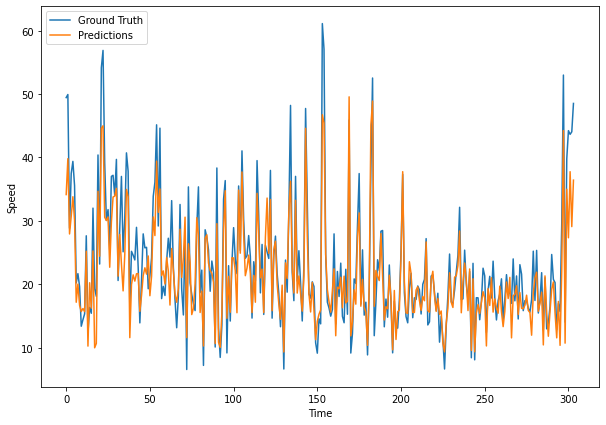

In [38]:
x, y = next(iter(test_iter))
model.eval()
y = y.cpu().numpy().reshape(-1)
y_pred = model(x).view(len(x), -1).cpu().detach().numpy().reshape(-1)

y = np.array(y * max_speed)
y_pred = np.array((y_pred) * max_speed)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(len(y[:304])), y[:304], label='Ground Truth')
plt.plot(range(len(y_pred[:304])), y_pred[:304], label='Predictions')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend(loc="upper left")
plt.show()

# References

-  Shin, Y., & Yoon, Y. (2020). Incorporating dynamicity of transportation network with multi-weight traffic graph convolutional network for traffic forecasting. IEEE Transactions on Intelligent Transportation Systems.

- https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html

- https://github.com/Aguin/STGCN-PyTorch